## Library Installation

In [1]:
"""!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install opencv-python
!pip install matplotlib
!pip install seaborn
!pip install tensorflow # Or !pip install torch torchvision torchaudio
!pip install Pillow"""

'!pip install numpy\n!pip install pandas\n!pip install scikit-learn\n!pip install opencv-python\n!pip install matplotlib\n!pip install seaborn\n!pip install tensorflow # Or !pip install torch torchvision torchaudio\n!pip install Pillow'

## Importing Libraries

In [2]:
# %% [markdown]
# # BBM 409 - Assignment 4: Bird Species Classification
# ## Part 0: Data Loading, Preprocessing, and Visualization

# %% Setup: Imports and Global Parameters
import os
import cv2 # OpenCV for image manipulation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical # For one-hot encoding
import random
import pandas as pd
from sklearn.manifold import TSNE # For t-SNE visualization
from sklearn.preprocessing import StandardScaler # For t-SNE

# --- USER CONFIGURABLE PARAMETERS ---
# !!! IMPORTANT: SET THIS TO YOUR DATASET PATH !!!
DATASET_BASE_DIR = 'Birds_25'  # Path to your 'Birds_25' directory

# Image dimensions for model input
IMG_WIDTH = 128
IMG_HEIGHT = 128

NUM_CLASSES = 25 # As per the assignment
# --- END USER CONFIGURABLE PARAMETERS ---

TRAIN_DIR = os.path.join(DATASET_BASE_DIR, 'train')
VALID_DIR = os.path.join(DATASET_BASE_DIR, 'valid')

2025-05-28 16:28:01.800690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748438881.888347  136656 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748438881.911872  136656 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748438882.060715  136656 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748438882.060745  136656 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748438882.060749  136656 computation_placer.cc:177] computation placer alr

## Step 1: Discover Species and Collect Image Paths

In [3]:
# %% [markdown]

# %% Step 1 Code
species_list = []
if os.path.exists(TRAIN_DIR):
    species_list = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
else:
    print(f"Warning: Training directory not found at '{TRAIN_DIR}'. Cannot determine species list automatically.")

if not species_list:
    print("Species list is empty. Please ensure your dataset is structured correctly and DATASET_BASE_DIR is set.")
else:
    print(f"Found {len(species_list)} species: {species_list[:5]}... (first 5 shown)")
    if len(species_list) != NUM_CLASSES:
        print(f"Warning: Found {len(species_list)} species folders, but expected {NUM_CLASSES}.")

all_original_train_paths = []
all_original_train_labels_str = []
all_original_valid_paths = []
all_original_valid_labels_str = []

for species_name in species_list:
    species_train_dir = os.path.join(TRAIN_DIR, species_name)
    if os.path.isdir(species_train_dir):
        for img_file in os.listdir(species_train_dir):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_original_train_paths.append(os.path.join(species_train_dir, img_file))
                all_original_train_labels_str.append(species_name)

    species_valid_dir = os.path.join(VALID_DIR, species_name)
    if os.path.isdir(species_valid_dir):
        for img_file in os.listdir(species_valid_dir):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                all_original_valid_paths.append(os.path.join(species_valid_dir, img_file))
                all_original_valid_labels_str.append(species_name)

print(f"\nTotal original training image paths collected: {len(all_original_train_paths)}")
print(f"Total original validation image paths collected: {len(all_original_valid_paths)}")

Found 25 species: ['Asian-Green-Bee-Eater', 'Brown-Headed-Barbet', 'Cattle-Egret', 'Common-Kingfisher', 'Common-Myna']... (first 5 shown)

Total original training image paths collected: 30000
Total original validation image paths collected: 7500


## Step 2: Encode Labels and Prepare 80-10-10 Split Paths


In [4]:
# %% Step 2 Code
label_encoder = LabelEncoder()
all_original_train_labels_encoded = label_encoder.fit_transform(all_original_train_labels_str)
all_original_valid_labels_encoded = label_encoder.transform(all_original_valid_labels_str)

label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}
print("\nLabel mapping (numerical_label: species_name):")
for i in range(min(5, len(label_mapping))): # Print first 5
    print(f"{i}: {label_mapping[i]}")
if len(label_mapping) > 5: print("...")


X_train_paths = []
y_train_labels_encoded = []
X_val_paths = []
y_val_labels_encoded = []
X_test_paths = []
y_test_labels_encoded = []

# Populate final training set (all original training images)
for i in range(len(all_original_train_paths)):
    X_train_paths.append(all_original_train_paths[i])
    y_train_labels_encoded.append(all_original_train_labels_encoded[i])

# Split original validation images per class into new validation and test sets
original_valid_paths_by_class = {}
for path, label_enc in zip(all_original_valid_paths, all_original_valid_labels_encoded):
    if label_enc not in original_valid_paths_by_class:
        original_valid_paths_by_class[label_enc] = []
    original_valid_paths_by_class[label_enc].append(path)

for class_label_enc, paths_for_class in original_valid_paths_by_class.items():
    species_name_temp = label_encoder.inverse_transform([class_label_enc])[0]
    if len(paths_for_class) != 300: # As per dataset description
        print(f"Info: Species '{species_name_temp}' has {len(paths_for_class)} original validation images (expected 300). Adjusting split.")
    
    random.shuffle(paths_for_class)
    split_point = len(paths_for_class) // 2

    X_val_paths.extend(paths_for_class[:split_point])
    y_val_labels_encoded.extend([class_label_enc] * len(paths_for_class[:split_point]))
    X_test_paths.extend(paths_for_class[split_point:])
    y_test_labels_encoded.extend([class_label_enc] * len(paths_for_class[split_point:]))

print(f"\n--- Dataset Split Path Counts ---")
print(f"Final training image paths: {len(X_train_paths)}")
print(f"Final validation image paths: {len(X_val_paths)}")
print(f"Final test image paths: {len(X_test_paths)}")

y_train_labels_encoded = np.array(y_train_labels_encoded)
y_val_labels_encoded = np.array(y_val_labels_encoded)
y_test_labels_encoded = np.array(y_test_labels_encoded)



Label mapping (numerical_label: species_name):
0: Asian-Green-Bee-Eater
1: Brown-Headed-Barbet
2: Cattle-Egret
3: Common-Kingfisher
4: Common-Myna
...

--- Dataset Split Path Counts ---
Final training image paths: 30000
Final validation image paths: 3750
Final test image paths: 3750


### Step 3: Image Loading and Preprocessing Functions (Separated)


In [5]:
# %% Step 3 Code
def load_raw_image_from_path(image_path):
    try:
        img_bgr = cv2.imread(image_path)
        if img_bgr is None:
            print(f"Warning (load_raw_image_from_path): Could not read image {image_path}.")
            return None
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        return img_rgb
    except Exception as e:
        print(f"Error loading raw image {image_path}: {e}")
        return None

def apply_model_preprocessing(raw_image_rgb, target_width, target_height):
    if raw_image_rgb is None: return None
    try:
        img_resized = cv2.resize(raw_image_rgb, (target_width, target_height))
        img_normalized = img_resized.astype('float32') / 255.0
        return img_normalized
    except Exception as e:
        print(f"Error applying model preprocessing: {e}")
        return None

def load_and_preprocess_data_separated(image_paths_list, labels_encoded_list, target_width, target_height):
    data, labels = [], []
    print(f"Starting to load and preprocess {len(image_paths_list)} images...")
    for i, path in enumerate(image_paths_list):
        raw_img = load_raw_image_from_path(path)
        if raw_img is not None:
            processed_img = apply_model_preprocessing(raw_img, target_width, target_height)
            if processed_img is not None:
                data.append(processed_img)
                labels.append(labels_encoded_list[i])
        if (i + 1) % 500 == 0 or (i + 1) == len(image_paths_list):
             print(f"  Processed {i+1}/{len(image_paths_list)} images for current set.")
    print(f"Finished. Successfully processed {len(data)} out of {len(image_paths_list)} images.")
    return np.array(data), np.array(labels)

# %% [markdown]


### Step 4: Visualization Functions


In [6]:

# %% Step 4 Code
def display_sample_images_from_paths(image_paths_list, numeric_labels_list, label_mapping_dict,
                                     num_samples_per_class=3, num_classes_to_display=5, title_prefix="Sample Raw"):
    if not image_paths_list or not numeric_labels_list.size:
        print("Image paths list or labels list is empty.")
        return

    paths_by_class = {}
    for path, label_numeric in zip(image_paths_list, numeric_labels_list):
        if label_numeric not in paths_by_class: paths_by_class[label_numeric] = []
        paths_by_class[label_numeric].append(path)

    unique_labels_available = list(paths_by_class.keys())
    if not unique_labels_available: return

    selected_labels_numeric = random.sample(unique_labels_available, min(num_classes_to_display, len(unique_labels_available)))

    plt.figure(figsize=(15, 3 * len(selected_labels_numeric)))
    plot_idx = 1
    for label_numeric in selected_labels_numeric:
        class_name = label_mapping_dict.get(label_numeric, f"Unknown {label_numeric}")
        class_image_paths = paths_by_class.get(label_numeric, [])
        sample_paths = random.sample(class_image_paths, min(num_samples_per_class, len(class_image_paths)))
        for i, img_path in enumerate(sample_paths):
            plt.subplot(len(selected_labels_numeric), num_samples_per_class, plot_idx)
            raw_img_to_display = load_raw_image_from_path(img_path)
            if raw_img_to_display is not None:
                plt.imshow(raw_img_to_display)
                plt.title(f"{title_prefix}: {class_name}\n(Original Dim.)")
            else:
                plt.title(f"{class_name}\nFailed to load")
            plt.axis('off')
            plot_idx += 1
    plt.suptitle(f"{title_prefix} Images Per Class", fontsize=16, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

def plot_class_distribution(y_numeric_list, label_mapping_dict, dataset_name="Dataset"):
    if not y_numeric_list.size:
        print(f"Label array for {dataset_name} is empty.")
        return
    unique_labels, counts = np.unique(y_numeric_list, return_counts=True)
    class_names = [label_mapping_dict.get(label, f"Unknown {label}") for label in unique_labels]
    
    df_counts = pd.DataFrame({'Species': class_names, 'Count': counts}).sort_values('Species')

    plt.figure(figsize=(14, 8))
    sns.barplot(x='Species', y='Count', data=df_counts, palette="viridis")
    plt.title(f'Class Distribution in {dataset_name} (Total: {sum(counts)} images)', fontsize=15)
    plt.xlabel('Bird Species', fontsize=12)
    plt.ylabel('Number of Samples', fontsize=12)
    plt.xticks(rotation=90, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def show_downscaling_effect_from_path(original_image_path, target_width, target_height):
    raw_img = load_raw_image_from_path(original_image_path)
    if raw_img is None:
        print(f"Could not load image for downscaling demo: {original_image_path}")
        return
    
    # Preprocess for downscaled version
    processed_img = apply_model_preprocessing(raw_img, target_width, target_height)
    if processed_img is None:
        print(f"Could not preprocess image for downscaling demo: {original_image_path}")
        return

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(raw_img)
    plt.title(f'Original Image\n({raw_img.shape[1]}x{raw_img.shape[0]})')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(processed_img) # This is normalized, imshow handles [0,1] floats
    plt.title(f'Downscaled & Normalized\n({target_width}x{target_height})')
    plt.axis('off')
    plt.suptitle("Image Downscaling and Preprocessing Effect", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def display_average_processed_images(X_processed, y_numeric_list, label_mapping_dict, num_classes_to_display=5):
    if not X_processed.size or not y_numeric_list.size:
        print("Processed data or labels are empty for average image display.")
        return
    unique_labels = np.unique(y_numeric_list)
    selected_labels = random.sample(list(unique_labels), min(num_classes_to_display, len(unique_labels)))
    
    plt.figure(figsize=(15, 3))
    for i, label_numeric in enumerate(selected_labels):
        class_images = X_processed[y_numeric_list == label_numeric]
        if class_images.shape[0] == 0: continue
        average_image = np.mean(class_images, axis=0)
        average_image = np.clip(average_image, 0, 1) # Ensure vals are in [0,1]

        plt.subplot(1, len(selected_labels), i + 1)
        plt.imshow(average_image)
        plt.title(f"Avg: {label_mapping_dict.get(label_numeric, str(label_numeric))}")
        plt.axis('off')
    plt.suptitle("Average Processed Images Per Class", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

def plot_color_histograms_for_raw_image(raw_image_rgb, title="Color Histogram"):
    if raw_image_rgb is None: return
    colors, channel_names = ('r', 'g', 'b'), ('Red', 'Green', 'Blue')
    plt.figure(figsize=(10, 5))
    plt.suptitle(title, fontsize=14)
    for i, color in enumerate(colors):
        # Ensure image is uint8 for calcHist if it's not already
        img_for_hist = raw_image_rgb
        if raw_image_rgb.dtype != np.uint8:
             # If it was float [0,1] for some reason, scale. But load_raw_image should give uint8.
             if raw_image_rgb.max() <= 1.0 and raw_image_rgb.min() >=0.0 :
                 img_for_hist = (raw_image_rgb * 255).astype(np.uint8)
             else: # Assume it's already in a good range for uint8 conversion
                 img_for_hist = raw_image_rgb.astype(np.uint8)

        histogram = cv2.calcHist([img_for_hist], [i], None, [256], [0, 256])
        plt.plot(histogram, color=color, label=f'{channel_names[i]} channel')
    plt.xlabel("Pixel Intensity (0-255)"); plt.ylabel("Number of Pixels")
    plt.legend(); plt.grid(True, linestyle='--', alpha=0.7); plt.xlim([0, 256])
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def plot_tsne_visualization_of_processed(X_processed, y_numeric_list, label_mapping_dict, n_samples_subset=1000, perplexity_val=30):
    if not X_processed.size or not y_numeric_list.size:
        print("Processed data or labels are empty for t-SNE.")
        return
    actual_samples = min(n_samples_subset, X_processed.shape[0])
    if actual_samples < perplexity_val + 2 : # Perplexity must be less than n_samples - 1
        print(f"Subset size {actual_samples} is too small for perplexity {perplexity_val}. Skipping t-SNE or try larger subset/smaller perplexity.")
        return
        
    print(f"\nPerforming t-SNE on a subset of {actual_samples} processed samples...")
    indices = np.random.choice(X_processed.shape[0], actual_samples, replace=False)
    X_subset, y_subset = X_processed[indices], y_numeric_list[indices]
    X_flattened = X_subset.reshape(actual_samples, -1)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_flattened)
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(perplexity_val, actual_samples-2), n_iter=300, verbose=0)
    X_tsne = tsne.fit_transform(X_scaled)

    plt.figure(figsize=(14, 10))
    unique_labels_in_subset = np.unique(y_subset)
    cmap = plt.cm.get_cmap('turbo', len(unique_labels_in_subset))

    for i, label_numeric in enumerate(unique_labels_in_subset):
        class_name = label_mapping_dict.get(label_numeric, str(label_numeric))
        plt.scatter(X_tsne[y_subset == label_numeric, 0], X_tsne[y_subset == label_numeric, 1],
                    label=class_name, alpha=0.8, color=cmap(i), s=50)
    plt.title(f't-SNE Visualization of {actual_samples} Processed Image Samples', fontsize=15)
    plt.xlabel('t-SNE Component 1'); plt.ylabel('t-SNE Component 2')
    if len(unique_labels_in_subset) <= 25: # Adjust if too many for legend
        plt.legend(loc='best', markerscale=1.0, bbox_to_anchor=(1.05, 1), title="Species")
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Make space for legend
    plt.show()


### Step 5: Data Visualizations of Original Data



--- Displaying Sample Raw Images from Training Paths ---


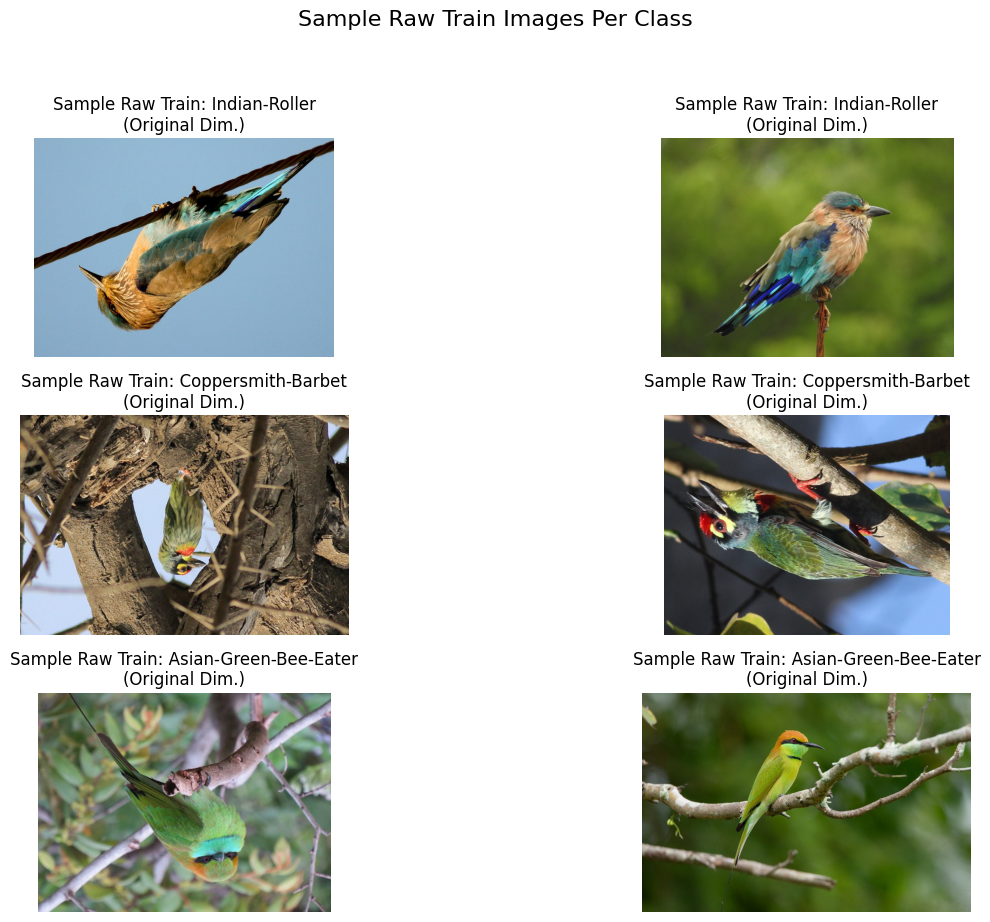


--- Displaying Downscaling Effect (using one training sample) ---


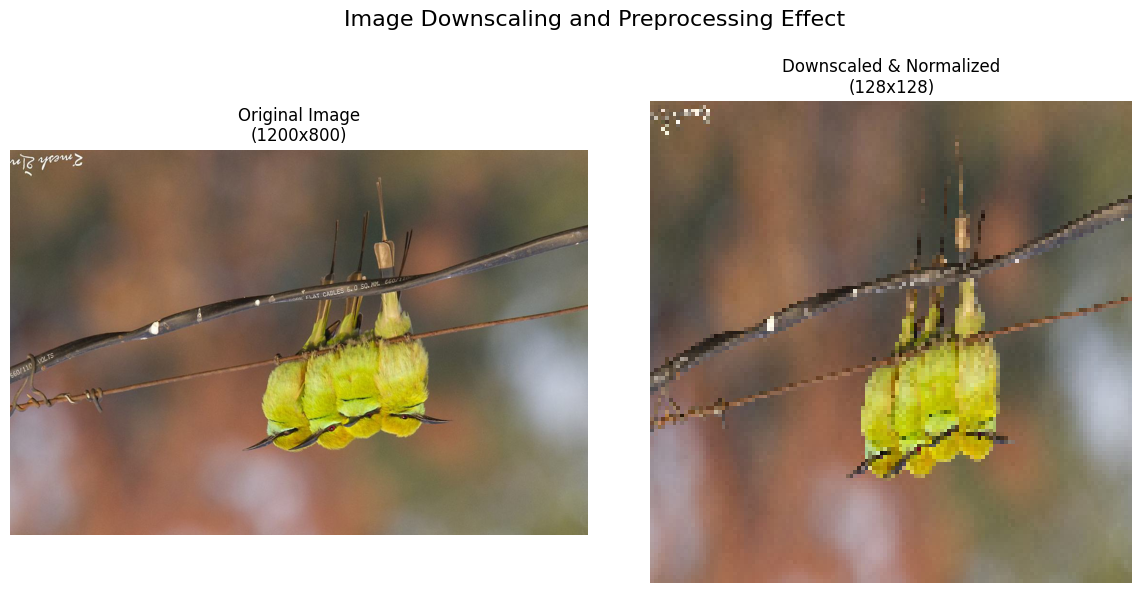


--- Displaying Color Histograms for a few Raw Training Samples ---


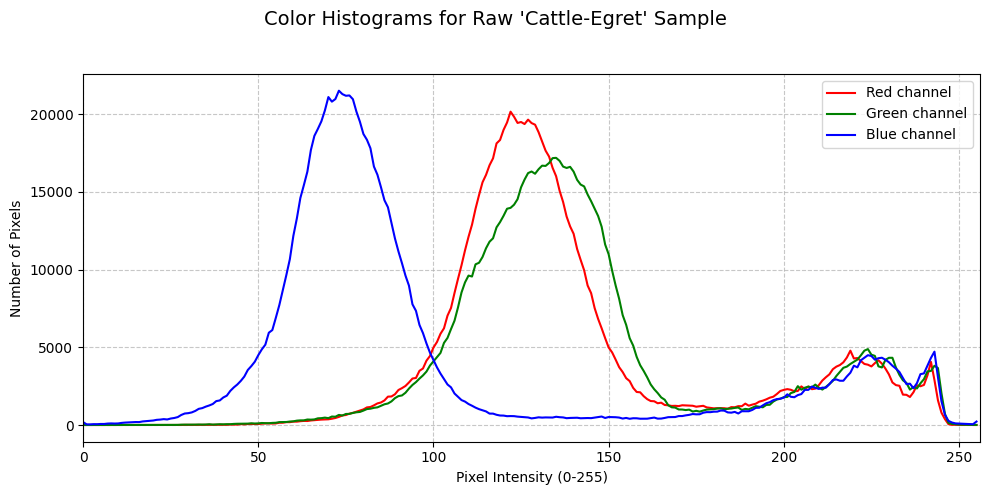

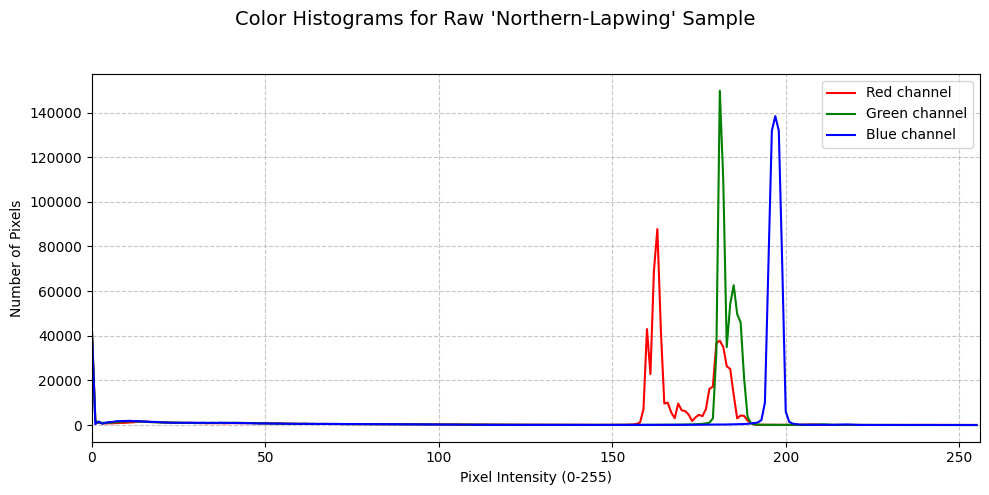


--- Plotting Class Distributions (based on path counts) ---


/tmp/ipykernel_136656/1015853115.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Species', y='Count', data=df_counts, palette="viridis")


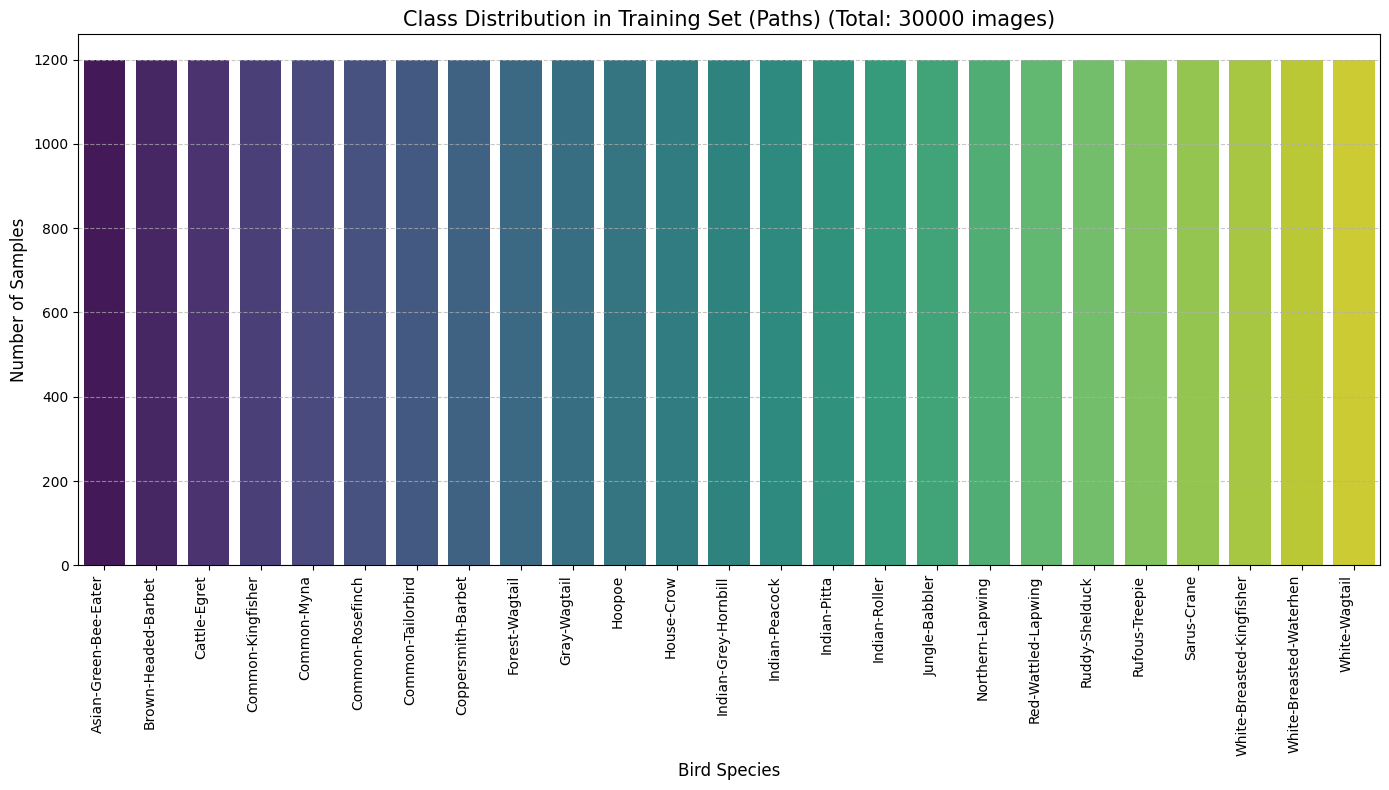

/tmp/ipykernel_136656/1015853115.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Species', y='Count', data=df_counts, palette="viridis")


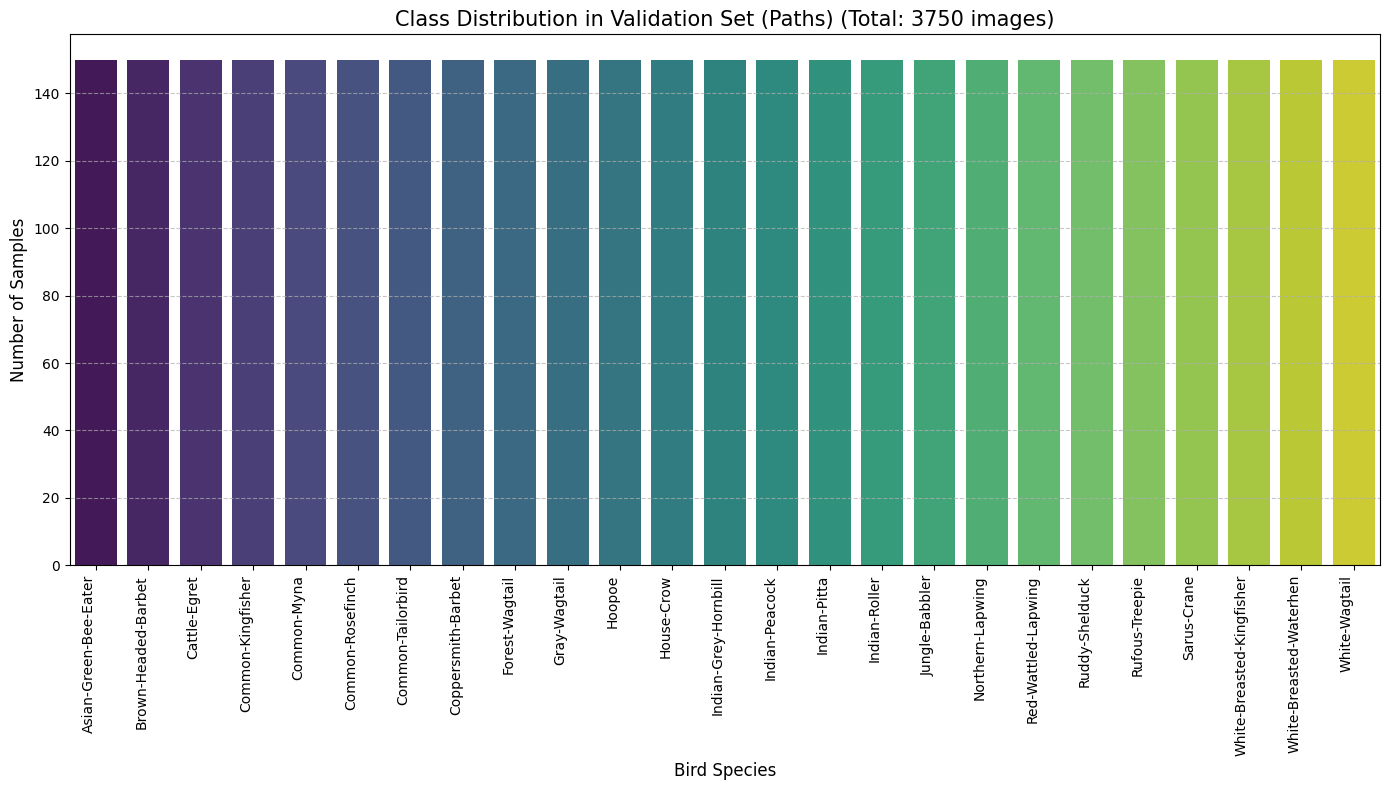

/tmp/ipykernel_136656/1015853115.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Species', y='Count', data=df_counts, palette="viridis")


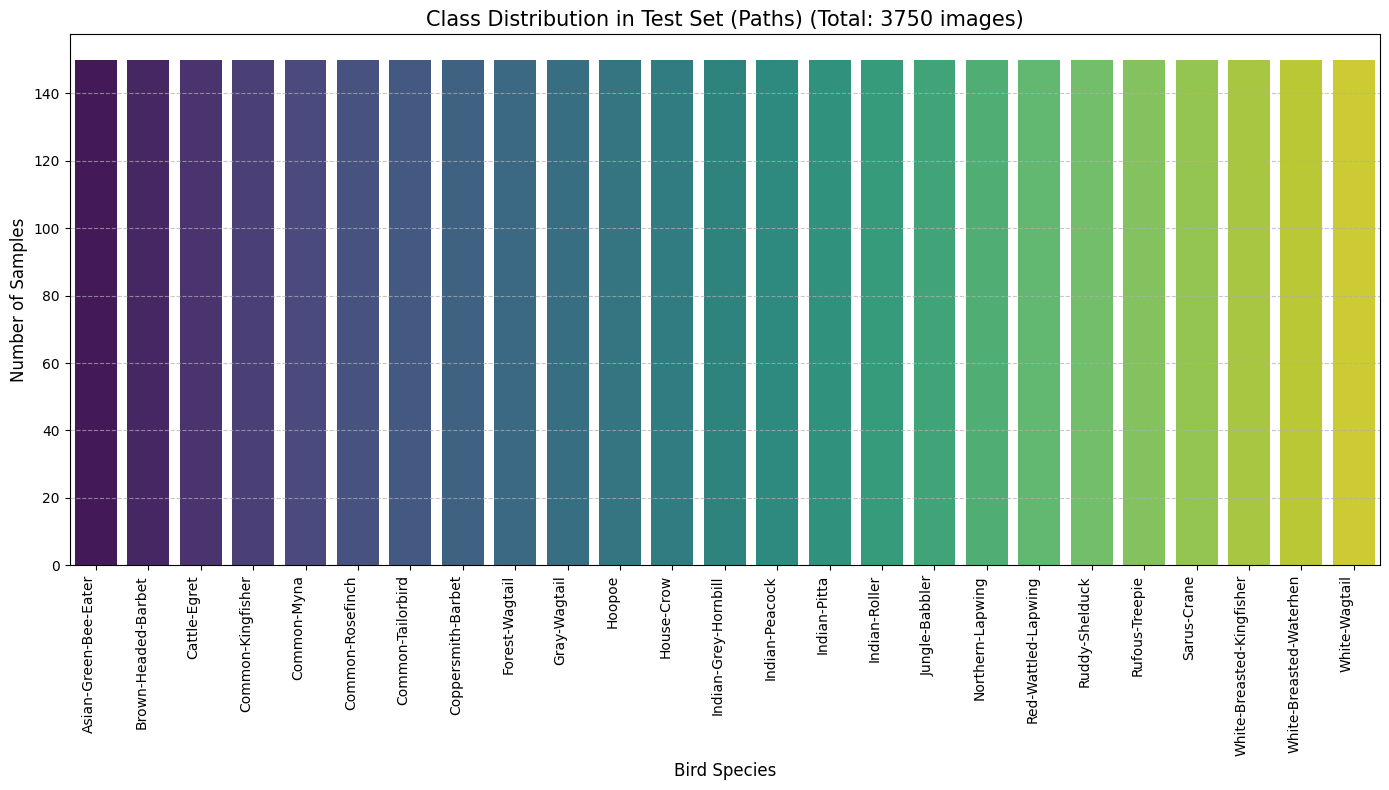

In [7]:

# %% [markdown]
# These visualizations use `load_raw_image_from_path` to show images closer to their original state.

# %% Step 5 Execution
if X_train_paths: # Check if paths were collected
    print("\n--- Displaying Sample Raw Images from Training Paths ---")
    display_sample_images_from_paths(X_train_paths, y_train_labels_encoded, label_mapping,
                                     num_samples_per_class=2, num_classes_to_display=3, title_prefix="Sample Raw Train")

    print("\n--- Displaying Downscaling Effect (using one training sample) ---")
    if X_train_paths:
         show_downscaling_effect_from_path(X_train_paths[0], IMG_WIDTH, IMG_HEIGHT)

    print("\n--- Displaying Color Histograms for a few Raw Training Samples ---")
    if len(X_train_paths) >=2:
        for i in range(2): # Show for 2 samples
            idx = random.randint(0, len(X_train_paths)-1)
            sample_path = X_train_paths[idx]
            raw_img = load_raw_image_from_path(sample_path)
            if raw_img is not None:
                species_name = label_mapping.get(y_train_labels_encoded[idx], "Unknown")
                plot_color_histograms_for_raw_image(raw_img, title=f"Color Histograms for Raw '{species_name}' Sample")
else:
    print("X_train_paths is empty. Skipping raw data visualizations.")


print("\n--- Plotting Class Distributions (based on path counts) ---")
if y_train_labels_encoded.size > 0:
    plot_class_distribution(y_train_labels_encoded, label_mapping, "Training Set (Paths)")
if y_val_labels_encoded.size > 0:
    plot_class_distribution(y_val_labels_encoded, label_mapping, "Validation Set (Paths)")
if y_test_labels_encoded.size > 0:
    plot_class_distribution(y_test_labels_encoded, label_mapping, "Test Set (Paths)")



### Step 6: Load and Preprocess All Data for Model Input



--- Loading and Preprocessing TRAINING Data for Model ---
Starting to load and preprocess 30000 images...
  Processed 500/30000 images for current set.
  Processed 1000/30000 images for current set.
  Processed 1500/30000 images for current set.
  Processed 2000/30000 images for current set.
  Processed 2500/30000 images for current set.
  Processed 3000/30000 images for current set.
  Processed 3500/30000 images for current set.
  Processed 4000/30000 images for current set.
  Processed 4500/30000 images for current set.
  Processed 5000/30000 images for current set.
  Processed 5500/30000 images for current set.
  Processed 6000/30000 images for current set.
  Processed 6500/30000 images for current set.
  Processed 7000/30000 images for current set.
  Processed 7500/30000 images for current set.
  Processed 8000/30000 images for current set.
  Processed 8500/30000 images for current set.
  Processed 9000/30000 images for current set.
  Processed 9500/30000 images for current set.
 

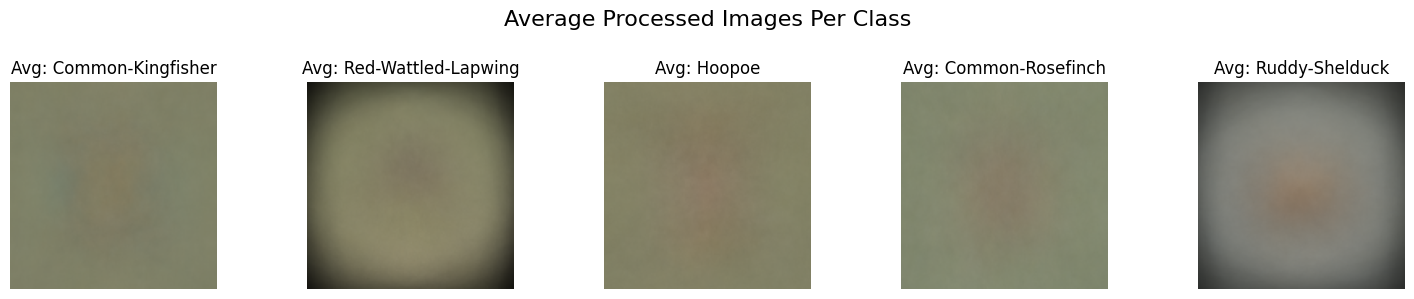


--- Displaying t-SNE of PROCESSED Training Data (subset) ---

Performing t-SNE on a subset of 1000 processed samples...


/home/sam/.pyenv/versions/3.9.22/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/tmp/ipykernel_136656/1015853115.py:149: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('turbo', len(unique_labels_in_subset))


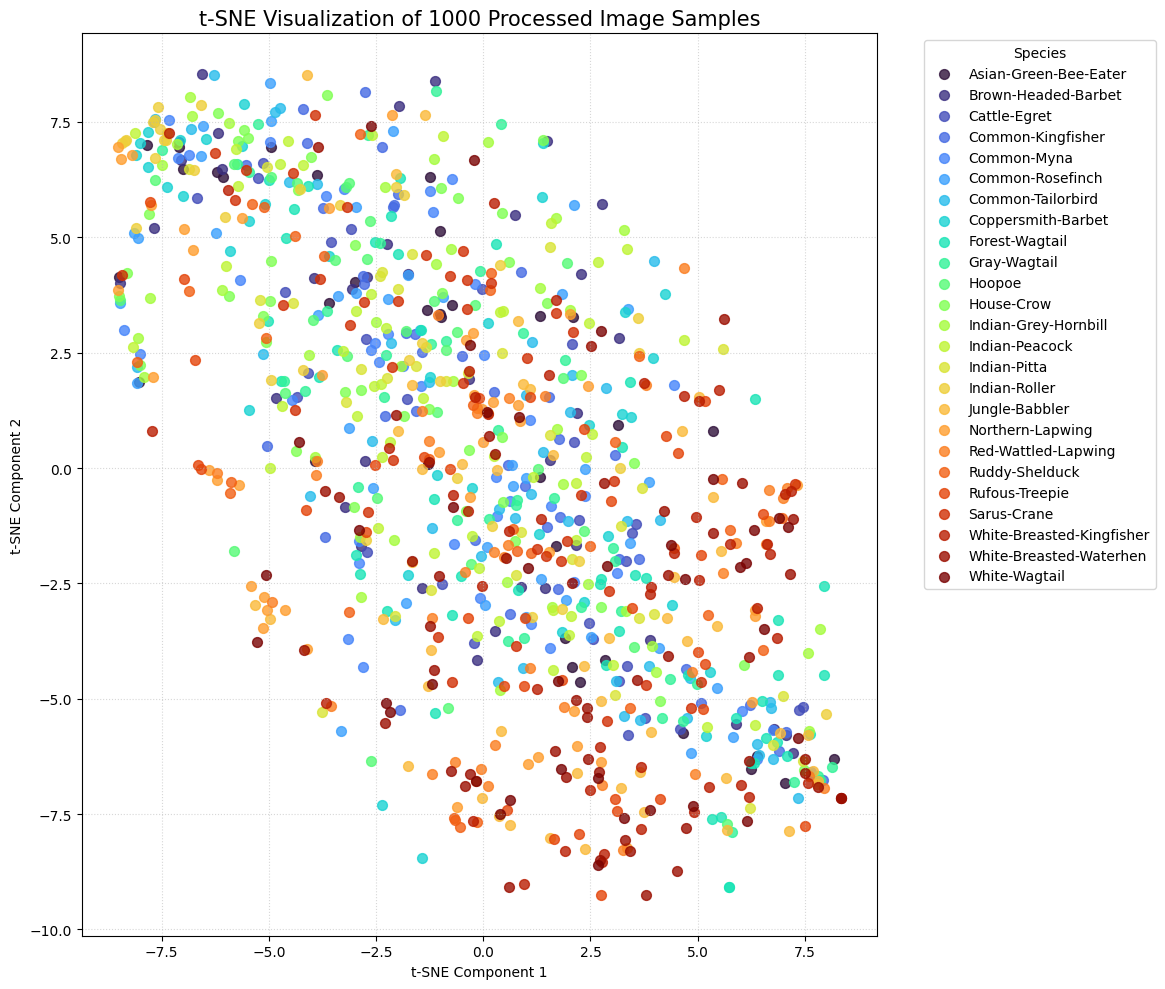


--- End of Data Loading, Preprocessing, and Visualization Script ---


In [8]:

# %% [markdown]
# This step will create `X_train`, `y_train`, `X_val`, `y_val`, `X_test`, `y_test` NumPy arrays with images resized and normalized.
# **WARNING: This can be time-consuming and memory-intensive!**

# %% Step 6 Execution
X_train, y_train, X_val, y_val, X_test, y_test = (np.array([]),)*6 # Initialize empty

if X_train_paths and y_train_labels_encoded.size > 0 :
    print("\n--- Loading and Preprocessing TRAINING Data for Model ---")
    X_train, y_train = load_and_preprocess_data_separated(X_train_paths, y_train_labels_encoded, IMG_WIDTH, IMG_HEIGHT)
    print(f"Model Training data shapes: X_train: {X_train.shape}, y_train: {y_train.shape}")
else:
    print("Skipping Training data loading due to missing paths or labels.")

if X_val_paths and y_val_labels_encoded.size > 0 :
    print("\n--- Loading and Preprocessing VALIDATION Data for Model ---")
    X_val, y_val = load_and_preprocess_data_separated(X_val_paths, y_val_labels_encoded, IMG_WIDTH, IMG_HEIGHT)
    print(f"Model Validation data shapes: X_val: {X_val.shape}, y_val: {y_val.shape}")
else:
    print("Skipping Validation data loading due to missing paths or labels.")

if X_test_paths and y_test_labels_encoded.size > 0 :
    print("\n--- Loading and Preprocessing TEST Data for Model ---")
    X_test, y_test = load_and_preprocess_data_separated(X_test_paths, y_test_labels_encoded, IMG_WIDTH, IMG_HEIGHT)
    print(f"Model Test data shapes: X_test: {X_test.shape}, y_test: {y_test.shape}")
else:
    print("Skipping Test data loading due to missing paths or labels.")

# Optional: One-hot encode labels for CNNs (if needed later)
# y_train_cat = to_categorical(y_train, num_classes=NUM_CLASSES)
# y_val_cat = to_categorical(y_val, num_classes=NUM_CLASSES)
# y_test_cat = to_categorical(y_test, num_classes=NUM_CLASSES)
# print(f"\nExample one-hot encoded y_train_cat shape: {y_train_cat.shape if y_train_cat.size > 0 else 'N/A'}")


# %% [markdown]
# ## Step 7: Execute Visualizations of Processed Data (Model Input Data)
# These visualizations operate on the `X_train`, etc., arrays which contain images resized to `IMG_WIDTH`x`IMG_HEIGHT` and normalized.

# %% Step 7 Execution
if X_train.size > 0 and y_train.size > 0:
    print("\n--- Displaying Average PROCESSED Images (from X_train) ---")
    display_average_processed_images(X_train, y_train, label_mapping, num_classes_to_display=5)

    print("\n--- Displaying t-SNE of PROCESSED Training Data (subset) ---")
    # Adjust n_samples_subset and perplexity_val as needed.
    # Perplexity should be less than n_samples_subset - 1.
    plot_tsne_visualization_of_processed(X_train, y_train, label_mapping,
                                         n_samples_subset=1000, perplexity_val=30) # Reduced for speed
else:
    print("X_train or y_train is empty. Skipping visualizations of processed data.")

print("\n--- End of Data Loading, Preprocessing, and Visualization Script ---")

In [11]:
!pip install scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 2.9 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.3/227.3 kB 2.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 3.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
